## Activate virtual environment

In [1]:
import os

path='/work/NLP_exam'
os.chdir(path)

# Make the activate.sh file executable
!chmod +x activate.sh

# Now run the script
!./activate.sh

Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


## Import packages

In [2]:
import os
import gensim
print(gensim.__version__)
from gensim.models.keyedvectors import KeyedVectors
from alignment_utils import smart_procrustes_align_gensim

ModuleNotFoundError: No module named 'gensim'

## Function for loading in word embedding models

In [45]:
def load_models(folder):
    """
    Load word embedding models from a folder.
    
    Args:
        folder (str): Path to the folder containing .w2v files.
    
    Returns:
        dict: A dictionary with years as keys and KeyedVectors as values.
    """
    models = {}
    for filename in os.listdir(folder):
        if filename.endswith(".w2v"):
            year = int(filename.split('.')[0])  # Extract year from filename
            model_path = os.path.join(folder, filename)
            models[year] = KeyedVectors.load(model_path)
            print(f"Loaded model for year {year}")
    return models

## Function for aligning word embedding models to base year using procrustes alignment

In [46]:
import numpy as np
import gensim

def smart_procrustes_align_gensim(base_embed, other_embed):
    """
    Aligns other_embed to base_embed using the Procrustes method.
    """
    # Intersection of vocabularies
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed)

    # Get the embedding matrices (access via `wv.vectors`)
    base_vecs = in_base_embed.wv.vectors
    other_vecs = in_other_embed.wv.vectors

    # Procrustes transformation
    m = other_vecs.T.dot(base_vecs)
    u, _, v = np.linalg.svd(m)
    ortho = u.dot(v)

    # Apply the transformation
    in_other_embed.wv.vectors = other_embed.wv.vectors.dot(ortho)
    return other_embed

def intersection_align_gensim(m1, m2):
    """
    Intersects the vocabularies of two gensim models and aligns indices.
    """
    # Access vocab through m.wv.key_to_index (for Word2Vec models)
    vocab_m1 = set(m1.wv.key_to_index.keys())
    vocab_m2 = set(m2.wv.key_to_index.keys())
    
    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2

    # Sorting by frequency
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, 'count') + m2.wv.get_vecattr(w, 'count'), reverse=True)

    for m in [m1, m2]:
        # Replace the embedding matrix with the common vocabulary
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Update index_to_key and key_to_index
        m.wv.index_to_key = common_vocab
        m.wv.key_to_index = {word: idx for idx, word in enumerate(common_vocab)}

    return m1, m2

In [47]:
def align_all_models(models, base_year):
    """
    Aligns a list of word embedding models to a common vector space using Procrustes alignment.
    
    Args:
        models (dict): A dictionary where keys are years and values are gensim KeyedVectors.
        base_year (int): The year of the model to use as the base for alignment.
    
    Returns:
        dict: A dictionary of aligned models.
    """
    # Select the base model
    base_model = models[base_year]
    aligned_models = {base_year: base_model}
    
    # Align each model to the base model
    for year, model in models.items():
        if year != base_year:
            print(f"Aligning year {year} to year {base_year}...")
            aligned_model = smart_procrustes_align_gensim(base_model, model)
            aligned_models[year] = aligned_model
    
    return aligned_models

## Function for saving aligned models to a specified folder

In [48]:
def save_aligned_models(aligned_models, output_folder):
    """
    Save aligned models to a specified folder.
    
    Args:
        aligned_models (dict): A dictionary of aligned models.
        output_folder (str): Path to the folder to save aligned models.
    """
    os.makedirs(output_folder, exist_ok=True)
    for year, model in aligned_models.items():
        model_path = os.path.join(output_folder, f"{year}.w2v")
        model.save(model_path)
        print(f"Saved aligned model for year {year} at {model_path}")


## Define input folder, output folder and base year

In [5]:
if __name__ == "__main__":
    input_folder = "/work/NLP_exam/models_1900_2000"  
    output_folder = "/work/NLP_exam/aligned_models"   
    base_year = 1900                   # Base year for alignment

    # Step 1: Load models
    print("Loading models...")
    models = load_models(input_folder)


Loading models...
Loaded model for year 1969
Loaded model for year 1935
Loaded model for year 1938
Loaded model for year 1966
Loaded model for year 1987
Loaded model for year 1990
Loaded model for year 1922
Loaded model for year 1997
Loaded model for year 1908
Loaded model for year 1991
Loaded model for year 1946
Loaded model for year 1937
Loaded model for year 1943
Loaded model for year 1914
Loaded model for year 1925
Loaded model for year 1950
Loaded model for year 1980
Loaded model for year 1964
Loaded model for year 1919
Loaded model for year 1947
Loaded model for year 1981
Loaded model for year 1906
Loaded model for year 1933
Loaded model for year 1967
Loaded model for year 1931
Loaded model for year 1904
Loaded model for year 1961
Loaded model for year 1977
Loaded model for year 1929
Loaded model for year 1934
Loaded model for year 1984
Loaded model for year 1902
Loaded model for year 1998
Loaded model for year 1999
Loaded model for year 1956
Loaded model for year 1982
Loaded mod

## Align and save aligned models

In [50]:
    # Step 2: Align models
    print(f"Aligning all models to the base model from year {base_year}...")
    aligned_models = align_all_models(models, base_year)

    # Step 3: Save aligned models
    print(f"Saving aligned models to folder: {output_folder}")
    save_aligned_models(aligned_models, output_folder)

Aligning all models to the base model from year 1900...
Aligning year 1969 to year 1900...
Aligning year 1935 to year 1900...
Aligning year 1938 to year 1900...
Aligning year 1966 to year 1900...
Aligning year 1987 to year 1900...
Aligning year 1990 to year 1900...
Aligning year 1922 to year 1900...
Aligning year 1997 to year 1900...
Aligning year 1908 to year 1900...
Aligning year 1991 to year 1900...
Aligning year 1946 to year 1900...
Aligning year 1937 to year 1900...
Aligning year 1943 to year 1900...
Aligning year 1914 to year 1900...
Aligning year 1925 to year 1900...
Aligning year 1950 to year 1900...
Aligning year 1980 to year 1900...
Aligning year 1964 to year 1900...
Aligning year 1919 to year 1900...
Aligning year 1947 to year 1900...
Aligning year 1981 to year 1900...
Aligning year 1906 to year 1900...
Aligning year 1933 to year 1900...
Aligning year 1967 to year 1900...
Aligning year 1931 to year 1900...
Aligning year 1904 to year 1900...
Aligning year 1961 to year 1900...

## Testing if the function works using only two models

In [51]:
#def test_procrustes_alignment(base_year, other_year, input_folder):
#    """
#    Test Procrustes alignment on two word embedding models.
#
#    Args:
#        base_year (int): The year of the base model.
#        other_year (int): The year of the other model to align.
#        input_folder (str): Path to the folder containing the models.
#
#    Returns:
#        KeyedVectors: The aligned version of the second model.
#    """
#    # Load the base model
#    base_path = os.path.join(input_folder, f"{base_year}.w2v")
#    base_model = KeyedVectors.load(base_path)
#    print(f"Loaded base model for year {base_year}.")
#
    # Load the other model
#    other_path = os.path.join(input_folder, f"{other_year}.w2v")
#    other_model = KeyedVectors.load(other_path)
#    print(f"Loaded other model for year {other_year}.")

    # Align the other model to the base model
#    print(f"Aligning year {other_year} to year {base_year}...")
#    aligned_model = smart_procrustes_align_gensim(base_model, other_model)

#    print(f"Alignment complete for year {other_year}.")
#    return aligned_model


# Main script for testing
#if __name__ == "__main__":
#    input_folder = "/work/NLP_exam/models_1900_2000"  # Path to your folder with models
#    base_year = 1900
#    other_year = 1901

    # Test alignment
#    print(f"Testing alignment between {base_year} and {other_year}...")
#    aligned_model = test_procrustes_alignment(base_year, other_year, input_folder)

    # Optionally save the aligned model for inspection
#    aligned_path = os.path.join("/work/NLP_exam/aligned_models", f"{other_year}_aligned_test.w2v")
#    aligned_model.save(aligned_path)
#    print(f"Aligned model for year {other_year} saved to {aligned_path}.")

## Visual inspection of alignment with TSNE

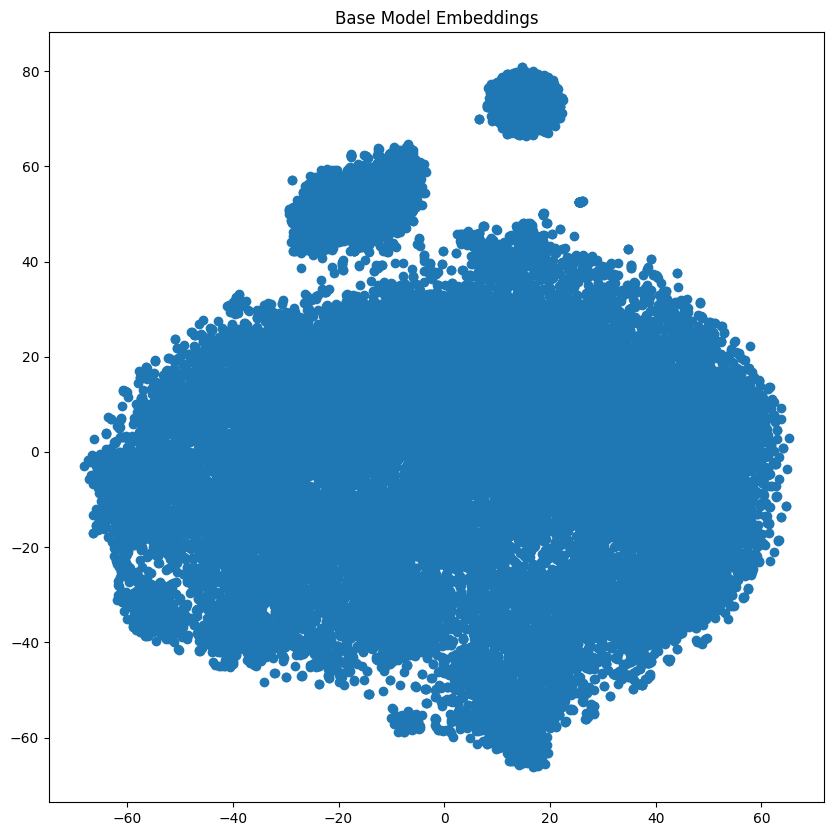

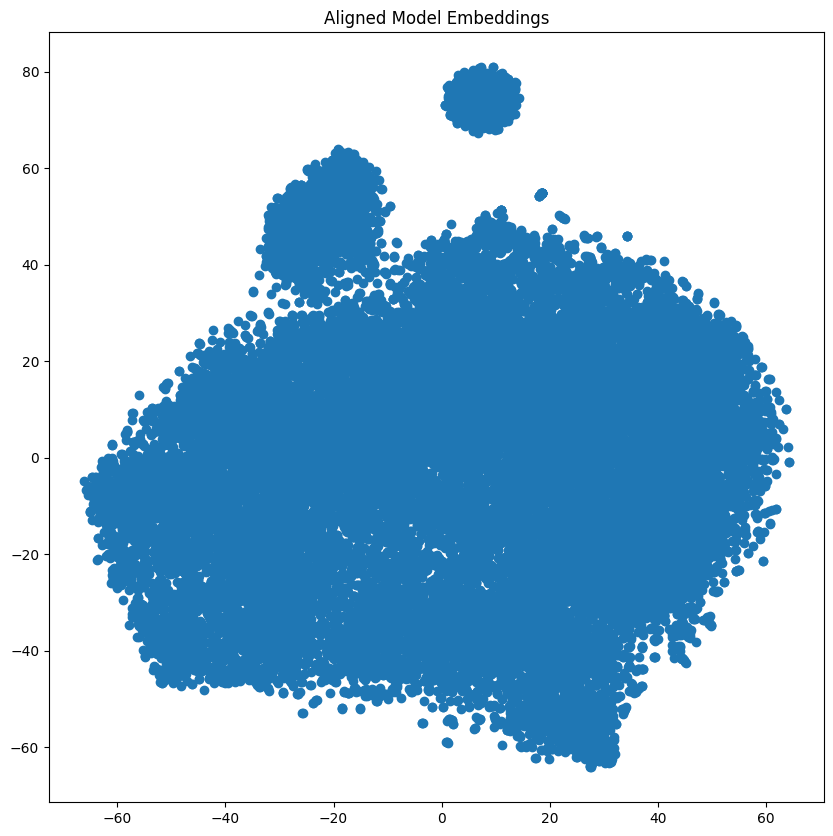

In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

# Load the models
base_model = Word2Vec.load("/work/NLP_exam/aligned_models/1900.w2v")
aligned_model = Word2Vec.load("/work/NLP_exam/aligned_models/1901.w2v")

def plot_embeddings(embedding, title=""):
    tsne = TSNE(n_components=2)
    reduced_embeddings = tsne.fit_transform(embedding)
    
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
    plt.title(title)
    plt.show()

# Before alignment (for comparison)
plot_embeddings(base_model.wv.vectors, title="Base Model Embeddings")

# After alignment
plot_embeddings(aligned_model.wv.vectors, title="Aligned Model Embeddings")

## Visual inspection with PCA

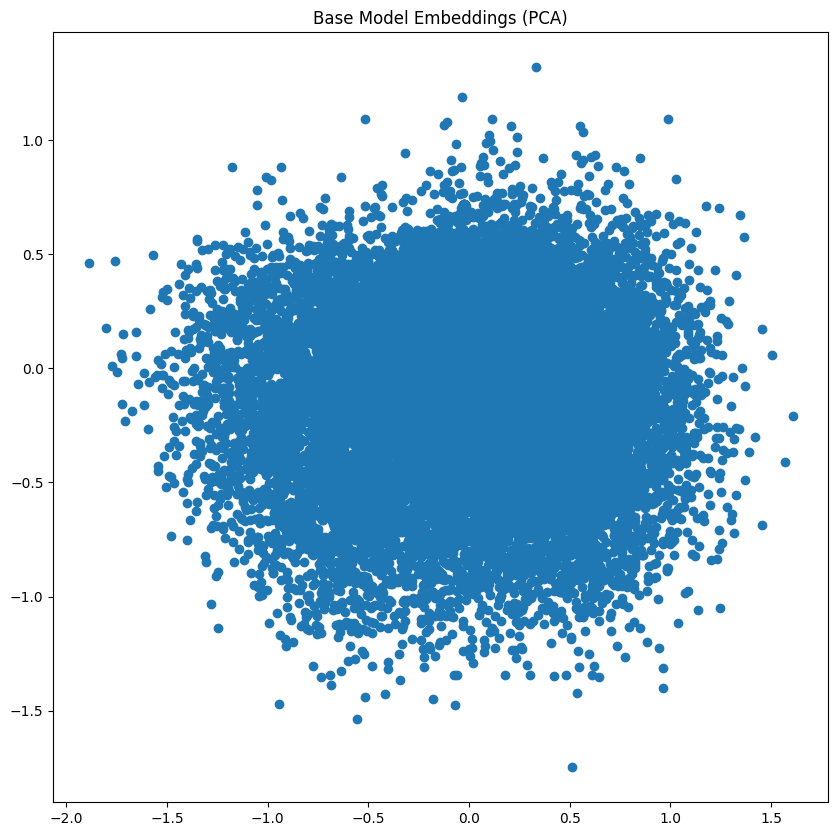

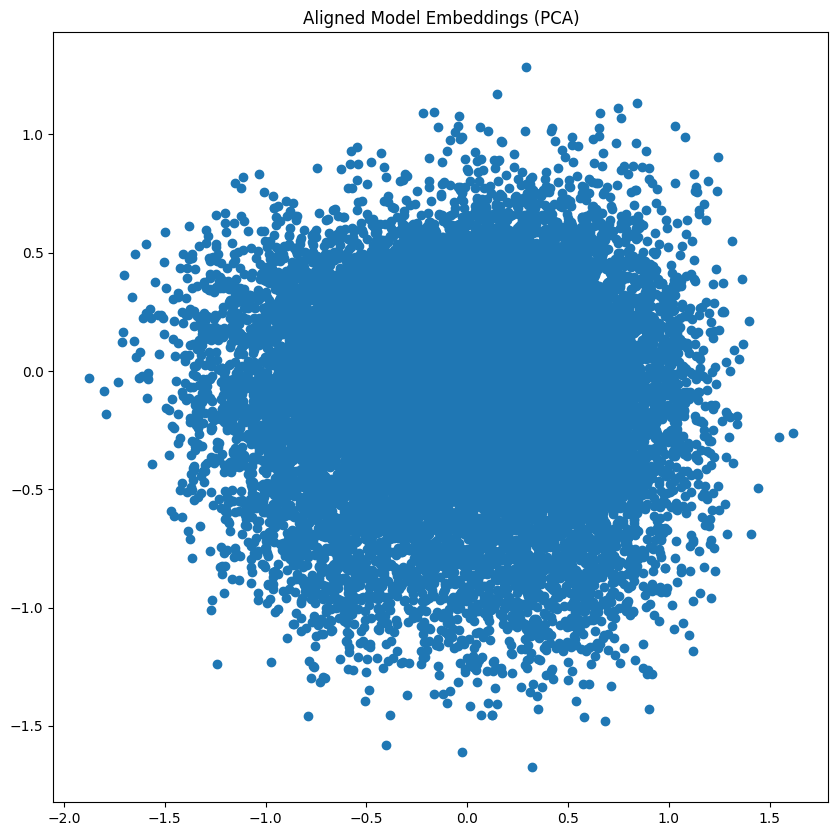

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_embeddings_with_pca(embedding, title=""):
    # Apply PCA to reduce dimensions to 2D
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embedding)
    
    # Plot the reduced embeddings in 2D space
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
    plt.title(title)
    plt.show()

# Before alignment (for comparison)
plot_embeddings_with_pca(base_model.wv.vectors, title="Base Model Embeddings (PCA)")

# After alignment
plot_embeddings_with_pca(aligned_model.wv.vectors, title="Aligned Model Embeddings (PCA)")

## Testing that the vectors are still unique

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate cosine similarity between two words in a model
def calculate_similarity(model, word1, word2):
    try:
        vector1 = model[word1]
        vector2 = model[word2]
        similarity = cosine_similarity([vector1], [vector2])[0][0]
        return similarity
    except KeyError as e:
        print(f"Word not found in vocabulary: {e}")
        return None

# Loading in models
from gensim.models import Word2Vec

# Load models
model_1900 = Word2Vec.load("/work/NLP_exam/aligned_models/1900.w2v").wv  
model_1999 = Word2Vec.load("/work/NLP_exam/aligned_models/1999.w2v").wv  

# Calculate similarity
similarity_1900 = calculate_similarity(model_1900, "man", "argue")
similarity_1999 = calculate_similarity(model_1999, "man", "argue")

similarity_1900_woman = calculate_similarity(model_1900, "woman", "argue")
similarity_1999_woman = calculate_similarity(model_1999, "woman", "argue")

# Print results
print(f"Similarity between 'man' and 'argue' in 1900 model: {similarity_1900}")
print(f"Similarity between 'man' and 'argue' in 1999 model: {similarity_1999}")

print(f"Similarity between 'woman' and 'argue' in 1900 model: {similarity_1900_woman}")
print(f"Similarity between 'woman' and 'argue' in 1999 model: {similarity_1999_woman}")

Similarity between 'man' and 'argue' in 1900 model: 0.47612807154655457
Similarity between 'man' and 'argue' in 1999 model: 0.32440972328186035
Similarity between 'woman' and 'argue' in 1900 model: 0.47443142533302307
Similarity between 'woman' and 'argue' in 1999 model: 0.3051333427429199


## Investigating how many words are in the vocabulary for the models

In [8]:
# Number of words in the 1900 model's vocabulary
num_words_1900 = len(model_1900.key_to_index)
print(f"Number of words in the 1900 model: {num_words_1900}")

num_words_1999 = len(model_1999.key_to_index)
print(f"Number of words in the 1999 model: {num_words_1999}")

Number of words in the 1900 model: 24642
Number of words in the 1999 model: 26109


In [9]:
#Verify that the size of the common vocabulary used for alignment matches the intersection of the two models
shared_vocab = set(model_1900.key_to_index.keys()) & set(model_1999.key_to_index.keys())
print(f"Shared vocabulary size: {len(shared_vocab)}")

Shared vocabulary size: 24642


## Compare the vectors before and after alignment

In [11]:
#load original models
original_model_1900 = Word2Vec.load("/work/NLP_exam/models_1900_2000/1900.w2v").wv  
original_model_1999 = Word2Vec.load("/work/NLP_exam/models_1900_2000/1999.w2v").wv 

def compare_word_vectors(word, model1, model2):
    try:
        vec1 = model1[word]
        vec2 = model2[word]
        similarity = cosine_similarity([vec1], [vec2])[0][0]
        return similarity
    except KeyError as e:
        print(f"Word not found in one of the models: {e}")
        return None

# Example: Similarity of "man" before and after alignment
pre_alignment_similarity = compare_word_vectors("man", original_model_1900, original_model_1999)
post_alignment_similarity = compare_word_vectors("man", model_1900, model_1999)

print(f"Similarity of 'man' before alignment: {pre_alignment_similarity}")
print(f"Similarity of 'man' after alignment: {post_alignment_similarity}")

Similarity of 'man' before alignment: 0.1804255247116089
Similarity of 'man' after alignment: 0.7769572138786316
